# Lecture 5: Notebook SK_01

## Sklearn Classification

In [1]:
import pandas as pd
import numpy as np

import sklearn
# import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### Import the dataset
Use pandas. The dataset is splitted in training and test. Create a `full_data` list where to save both.

In [2]:
train = pd.read_csv("titanic/train.csv")
test = pd.read_csv("titanic/test.csv")
full_data = [train, test]

Print dataset shape

In [3]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


Print dataset head and tail

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Features

__Survived:__
```
0 = No, 1 = Yes
```

__Pclass:__
```
A proxy for socio-economic status (SES)
1 = 1st, 2 = 2nd, 3 = 3rd
1st = Upper
2nd = Middle
3rd = Lower
```

__sex:__
```
Sex
```

__age:__
```
Age is fractional if less than 1. If estimated: is it in the form of xx.5
```

__SibSp:__
```
# of siblings / spouses aboard the Titanic
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)
```

__Parch:__
```
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.
```

__Ticket:__
```
Ticket number
```

__Fare:__
```
Passenger fare
```

__Cabin:__
```
Cabin number
```

__Embarked:__
```
Port of Embarkation
C = Cherbourg, Q = Queenstown, S = Southampton
```

### Phase 1 : Feature Exploration, Engineering and Cleaning
* explore the data
* identify feature engineering opportunities
* numerically encode any categorical features

Check for nan values in each colum

In [6]:
for cc in train.columns:
    if train[cc].isnull().values.any():
        print(cc, train[cc].isnull().sum())

Age 177
Cabin 687
Embarked 2


We cannot remove all the nan data, otherwise we remove a great portion of the dataset.
We have to fill missing data.

#### Fix Age

plot Age histogram

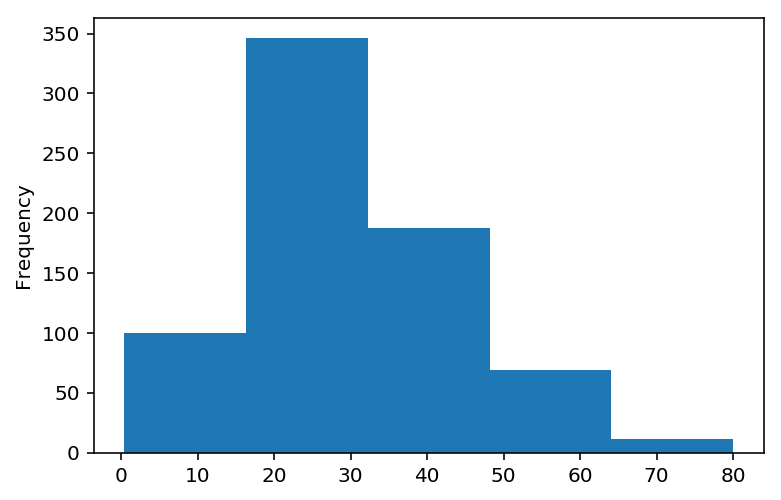

In [7]:
train['Age'].plot.hist(bins=5)

Add missing values using avg values

In [8]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    d1 = age_avg - age_std
    d2 = age_avg + age_std
    age_null_random_list = np.random.randint(d1, d2, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

Use `pd.cut` to bin values into discrete intervals

In [9]:
ll = [0,1,2,3,4]
train['Age'], bins = pd.cut(train['Age'], 5, retbins=True, labels=ll)
print(bins)

[-0.08 16.   32.   48.   64.   80.  ]


In [10]:
test['Age'], _ = pd.cut(test['Age'], bins, retbins=True, labels=ll)

for dataset in full_data:
    dataset['Age'] = dataset['Age'].astype(int)

#### Fix cabin
Create a new `has_cabin` feature 

In [11]:
for dataset in full_data:
    dataset['Has_cabin'] = 0
    dataset['Has_cabin'][dataset['Cabin'].notnull()] = 1

#### Fix Embarked

In [12]:
# dataset['Embarked'].count()
# dataset.groupby('Embarked').count()

# We will fill nan values with S
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = dataset['Embarked'].map({'C':0, 'Q':1, 'S': 2}).astype(int)

#### Extract others features

Plot `Fare` histogram

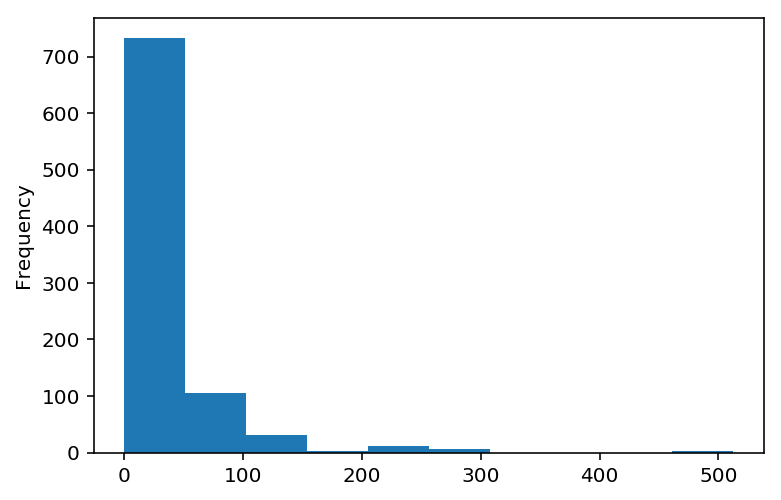

In [13]:
train['Fare'].plot.hist()

Use `pd.cut` to bin values into discrete intervals

In [14]:
for dataset in full_data:
    dataset['Fare'] = pd.cut(dataset['Fare'], 4, labels=[0,1,2,3])
    dataset['Fare'] = dataset['Fare'].astype(int)

Create new `FamilySize` and `isAlone` features

In [15]:
for dataset in full_data:
    dataset['Family_size'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['Is_alone'] = 0
    dataset['Is_alone'][dataset['Family_size'] == 1] = 1

Map `Sex` into numbers

In [16]:
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)

#### Remove unused data

Print dataset columns

In [17]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Has_cabin',
       'Family_size', 'Is_alone'],
      dtype='object')

Remove the following columns `'PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'`

In [18]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
train  = train.drop(drop_elements, axis=1)
test  = test.drop(drop_elements, axis=1)

Prin `train` and `test` head

In [19]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Has_cabin,Family_size,Is_alone
0,0,3,1,1,0,2,0,2,0
1,1,1,0,2,0,0,1,2,0
2,1,3,0,1,0,2,0,1,1
3,1,1,0,2,0,2,1,2,0
4,0,3,1,2,0,2,0,1,1


In [20]:
test.head()

,Pclass,Sex,Age,Fare,Embarked,Has_cabin,Family_size,Is_alone
0,3,1,2,0,1,0,1,1
1,3,0,2,0,2,0,2,0
2,2,1,3,0,1,0,1,1
3,3,1,1,0,2,0,1,1
4,3,0,1,0,2,0,3,0


In [21]:
print(train.shape)
print(test.shape)

train.to_csv("titanic/train_p.csv")
test.to_csv("titanic/test_p.csv")

(891, 9)
(418, 8)


In [22]:
train = pd.read_csv("titanic/train_p.csv", index_col=0)
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Has_cabin,Family_size,Is_alone
0,0,3,1,1,0,2,0,2,0
1,1,1,0,2,0,0,1,2,0
2,1,3,0,1,0,2,0,1,1
3,1,1,0,2,0,2,1,2,0
4,0,3,1,2,0,2,0,1,1


### Visualization

#### Plot the Pearson correlation coefficient

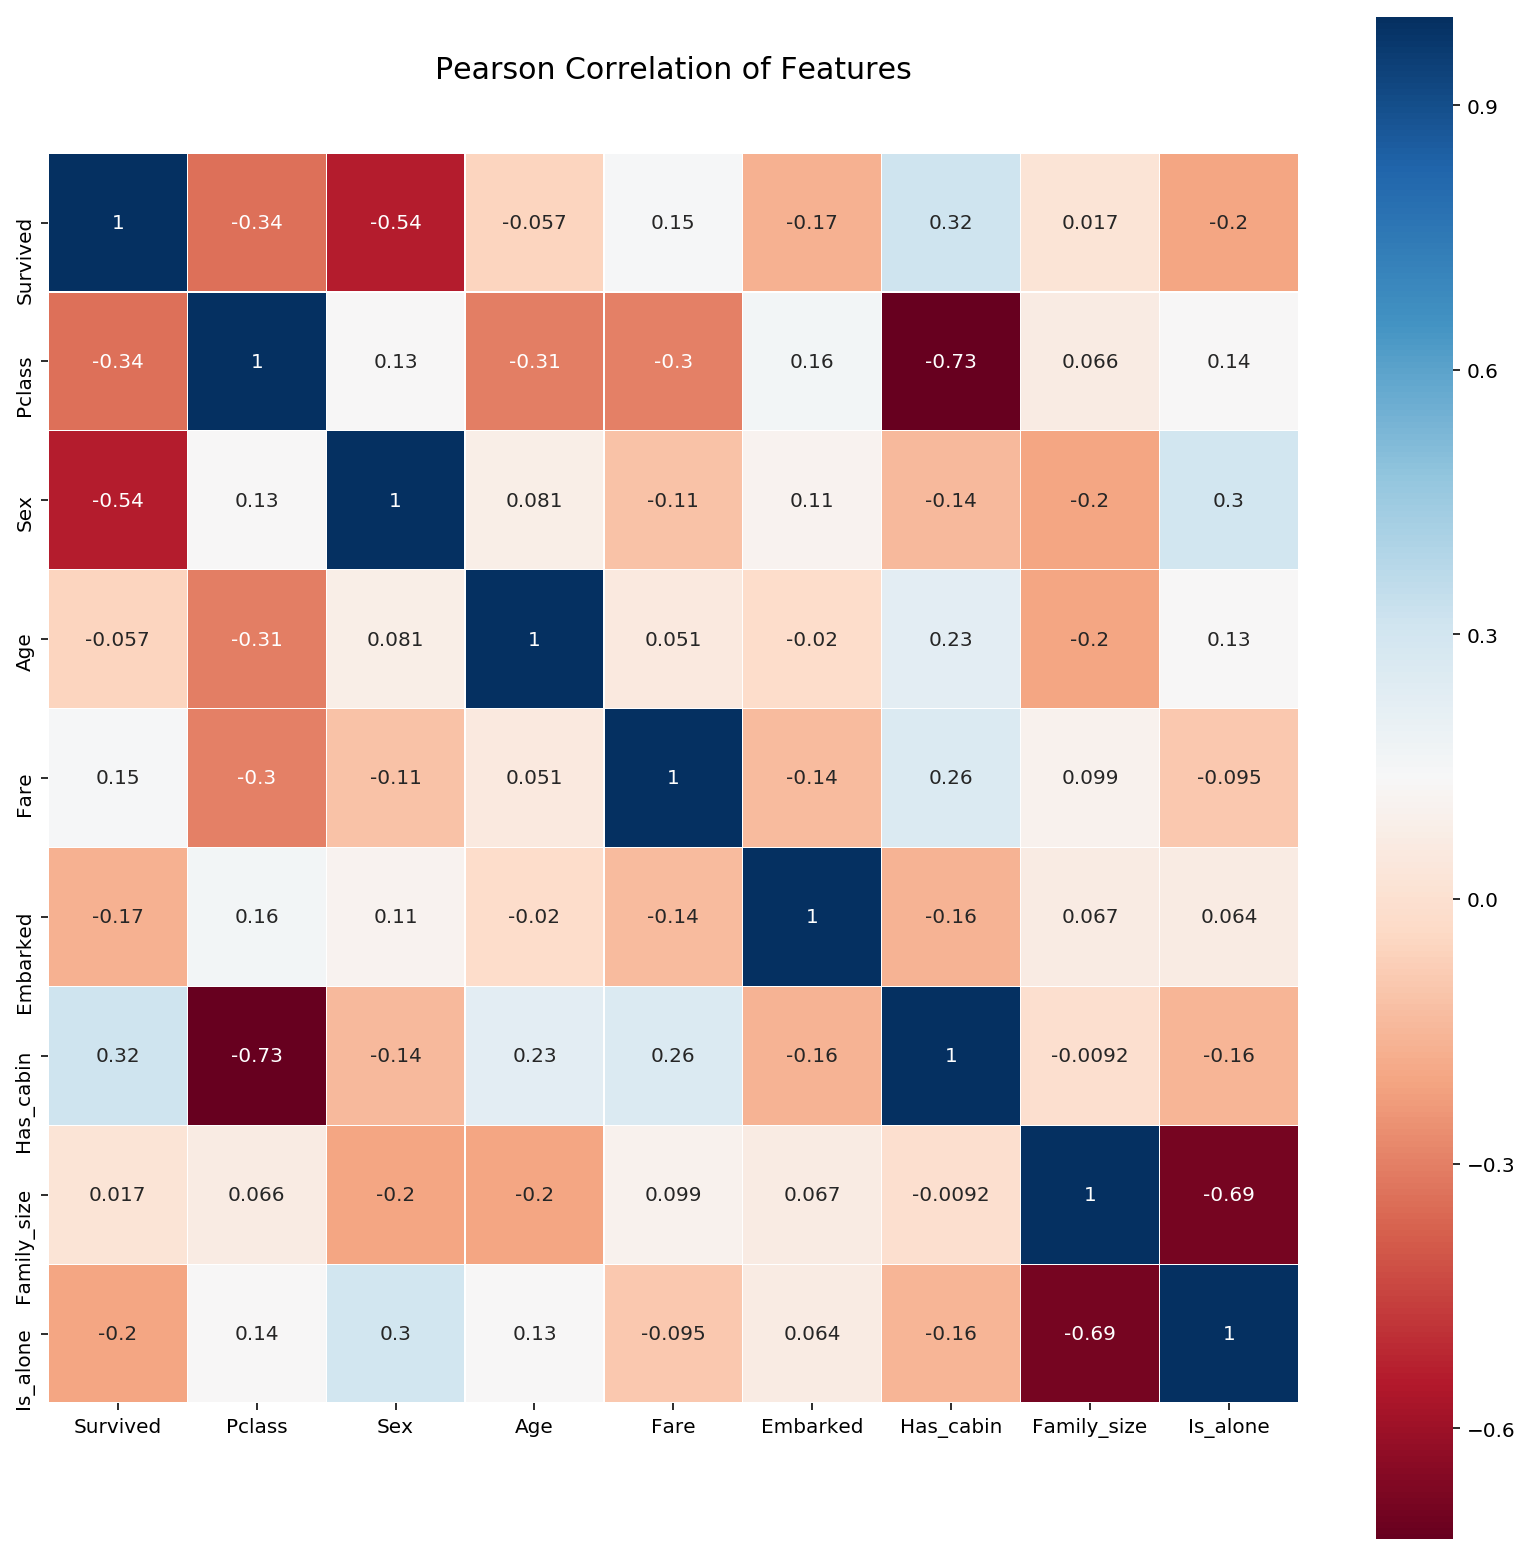

In [23]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,14))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

The Pearson correlation coefficient ranges from −1 to 1. A value of 1 implies that a linear equation describes the relationship between X and Y perfectly, with all data points lying on a line for which Y increases as X increases. A value of −1 implies that all data points lie on a line for which Y decreases as X increases. A value of 0 implies that there is no linear correlation between the variables.

About the dataset:

"One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. "

#### Plot the pairplot of each pair of features

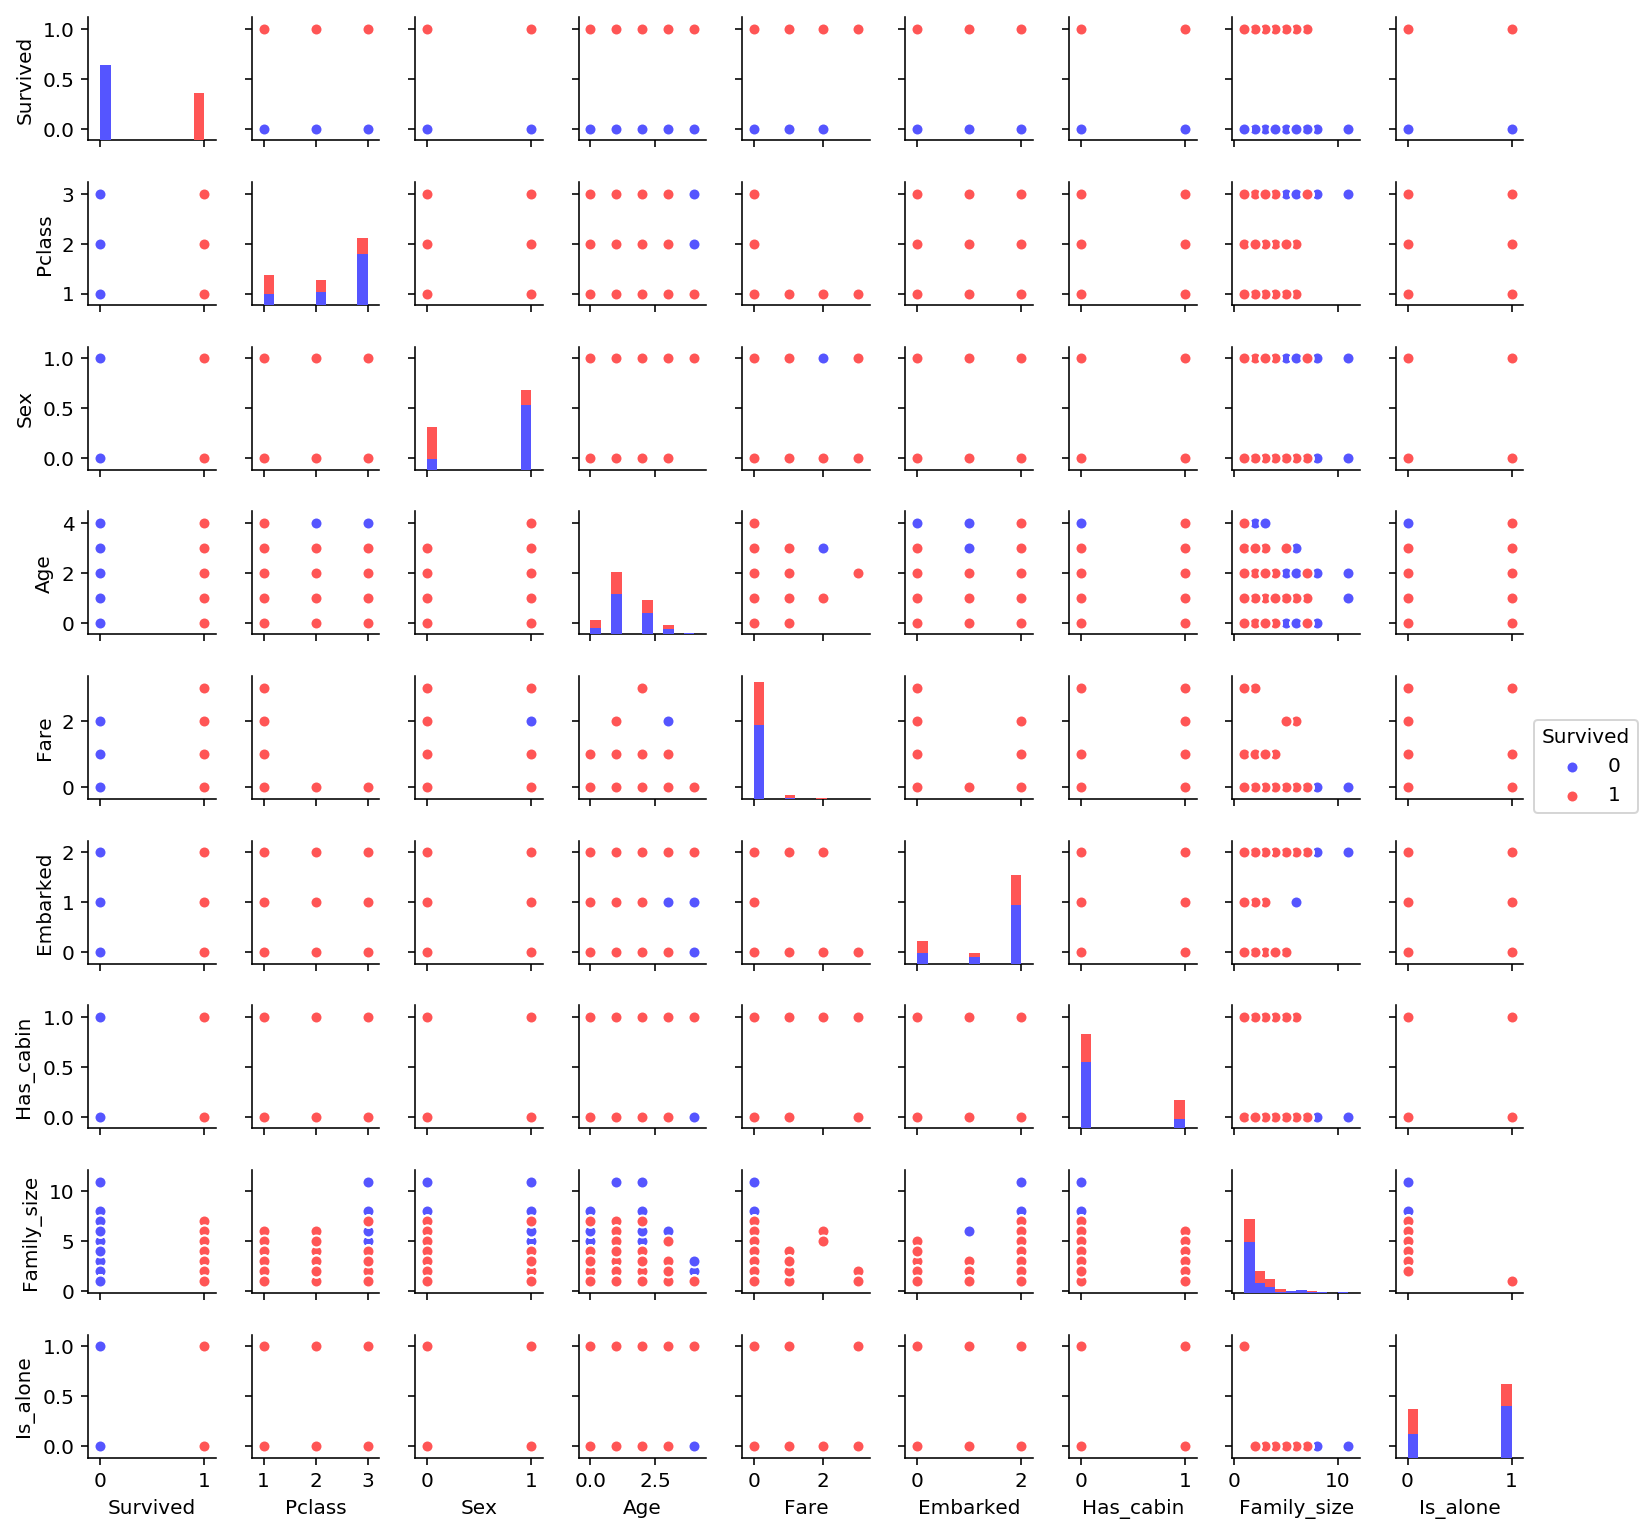

In [24]:
sns.pairplot(train, hue='Survived', palette='seismic', size=1.2)

### Phase 2 :  Let's train

Split the dataset in `X`, `y`, and `X_validation`.

Use the following columns `'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Has_cabin', 'Family_size', 'Is_alone'` in `X`

In [25]:
cols = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Has_cabin', 'Family_size', 'Is_alone']
X = train[cols].values
y = train['Survived'].values

# we will not use it!
X_validation = test.values

Set the `SEED` for reproducibility, and `NFOLDS` for out-of-fold prediction

In [26]:
SEED = 14
NFOLD = 5

Create a *logistic regressor* and compute the __accuracy__ using cross validation

In [27]:
logreg = LogisticRegression(n_jobs=-1)
cross_val_score(logreg, X, y, cv=NFOLD, n_jobs=-1, scoring='accuracy')

array([0.77653631, 0.80446927, 0.79213483, 0.79213483, 0.80225989])

### Phase 3 : features selection

Train different models using the following parameters:

In [28]:
# Random Forest Parameters
rf_params = {
    'random_state' : SEED,
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True, 
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'random_state' : SEED,
    'n_jobs': -1,
    'n_estimators':500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'random_state' : SEED,
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'random_state' : SEED,
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

Create the models: ```RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier```

In [29]:
rf = RandomForestClassifier(**rf_params)
et = ExtraTreesClassifier(**et_params)
ad = AdaBoostClassifier(**ada_params)
gb = GradientBoostingClassifier(**gb_params)

Fit all the models on `X` and `y`

In [30]:
rf.fit(X, y)
et.fit(X, y)
ad.fit(X, y)
gb.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=14, subsample=1.0, verbose=0,
              warm_start=False)

Create a dataframe with `features_importances_`

In [31]:
fd = pd.DataFrame()
fd['features'] = cols
fd['rf'] = rf.feature_importances_
fd['et'] = et.feature_importances_
fd['ad'] = ad.feature_importances_
fd['gb'] = gb.feature_importances_

fd

,features,rf,et,ad,gb
0,Pclass,0.161869,0.145816,0.156,0.164077
1,Sex,0.468363,0.534682,0.054,0.110480
2,Age,0.075423,0.057287,0.052,0.202479
3,Fare,0.016433,0.012366,0.120,0.021667
4,Embarked,0.047875,0.039915,0.174,0.149138
5,Has_cabin,0.098804,0.110075,0.056,0.088262
6,Family_size,0.097053,0.059957,0.362,0.208085
7,Is_alone,0.034181,0.039902,0.026,0.055813


Plot each of them

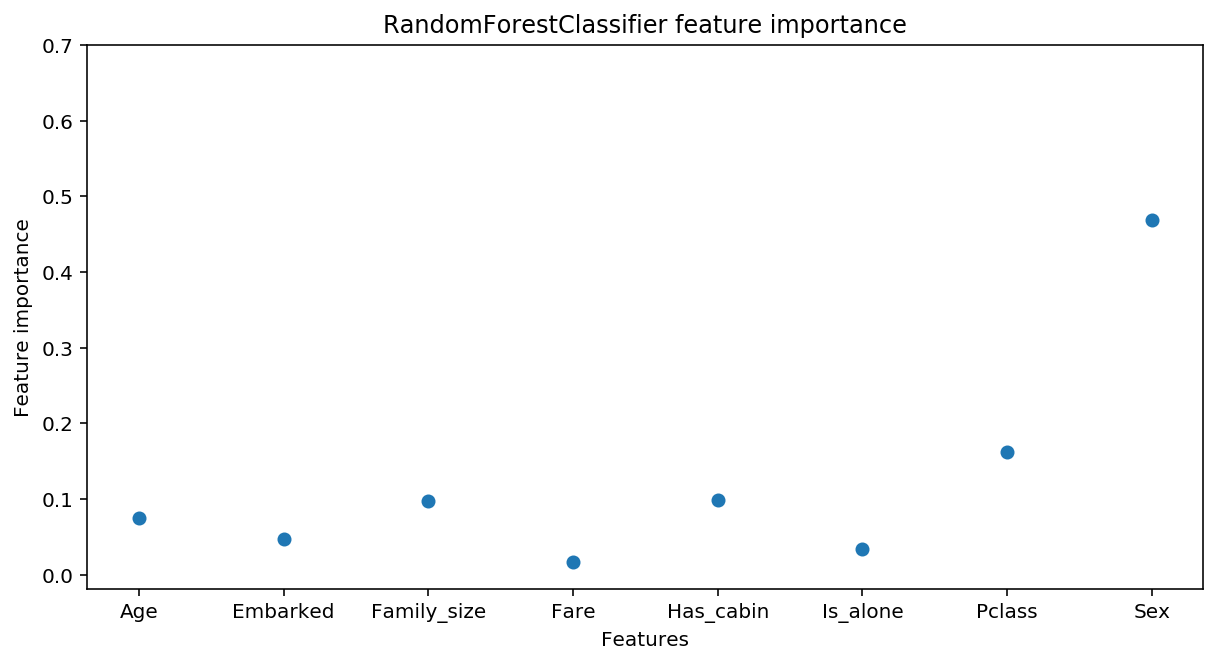

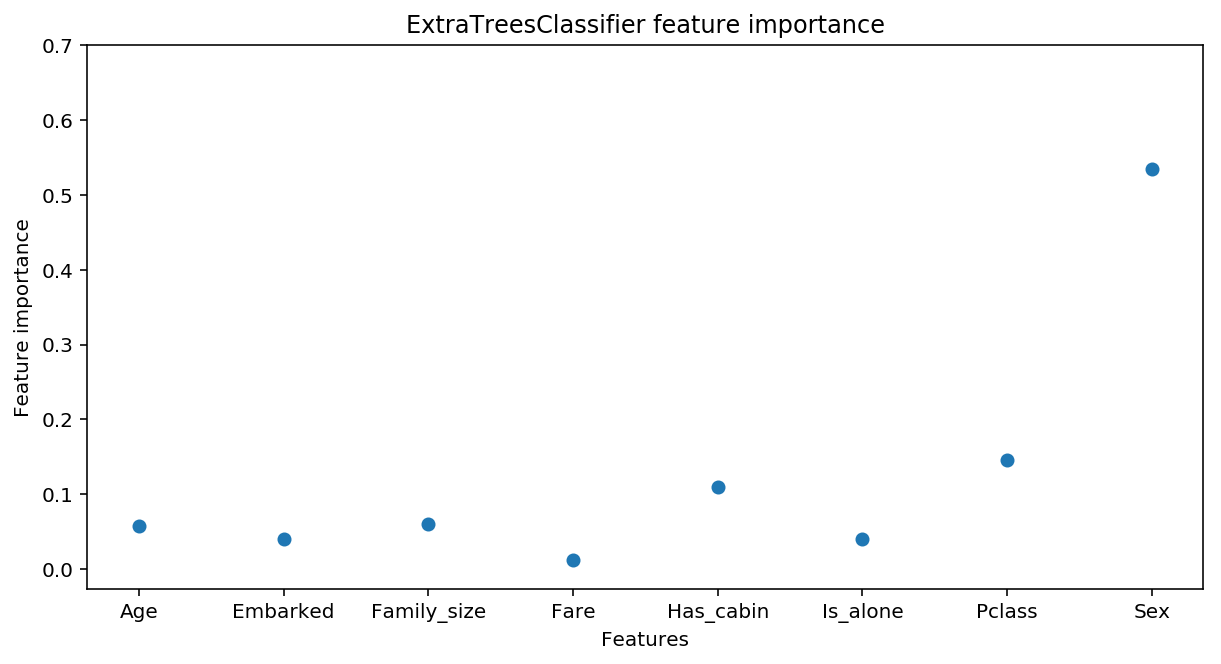

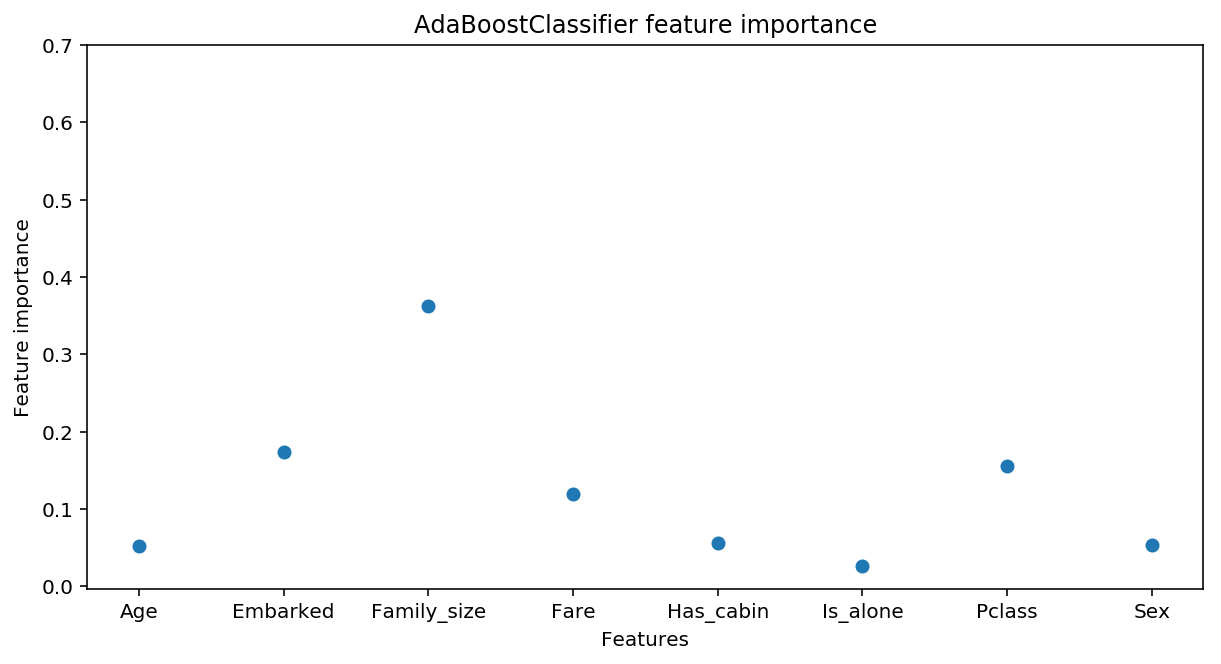

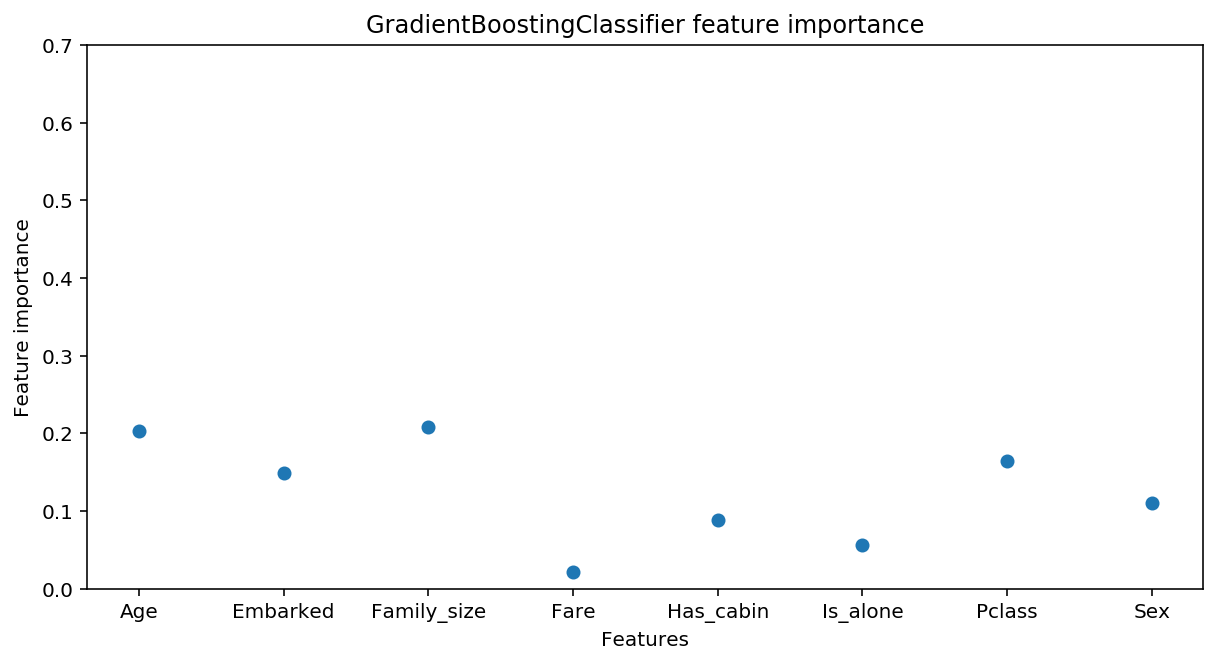

In [32]:
names = ['RandomForestClassifier', 'ExtraTreesClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier']
for c, t in enumerate(['rf', 'et', 'ad', 'gb']):
    plt.figure(figsize=(10,5))
    plt.scatter(fd['features'].values, fd[t].values)
    plt.ylim(ymax=0.7)
    plt.xlabel("Features")
    plt.ylabel("Feature importance")
    plt.title("%s feature importance" % names[c])

### Phase 4 : Select a Model

#### Let's make everything a bit more automated

In [33]:
cls_names = ['LogisticRegression',
'KNeighborsClassifier',
'SVC',
'GaussianProcessClassifier',
# 'RBF',
'DecisionTreeClassifier',
'RandomForestClassifier',
'AdaBoostClassifier',
'GradientBoostingClassifier',
'ExtraTreesClassifier',
'GaussianNB',
'QuadraticDiscriminantAnalysis']

In [34]:
cls_functions= [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(),
    GaussianProcessClassifier(),
#     RBF(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    ExtraTreesClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

In [35]:
for name, clf in zip(cls_names, cls_functions):
    accuracy = cross_val_score(clf, X, y, cv=NFOLD, scoring='accuracy').mean()
    recall = cross_val_score(clf, X, y, cv=NFOLD, scoring='recall').mean()
    print("%-32s %-10f %-10f" % (name, accuracy, recall))

LogisticRegression               0.793507   0.707460  
KNeighborsClassifier             0.782258   0.672379  
SVC                              0.818202   0.704433  
GaussianProcessClassifier        0.803670   0.696036  
DecisionTreeClassifier           0.793570   0.646292  
RandomForestClassifier           0.795779   0.675575  
AdaBoostClassifier               0.804775   0.736616  
GradientBoostingClassifier       0.821635   0.701833  
ExtraTreesClassifier             0.795773   0.649233  
GaussianNB                       0.763352   0.643606  
QuadraticDiscriminantAnalysis    0.785717   0.733760  


### Phase 5 : Tune parameters

Let's try different parameters for `GradientBoostingClassifier`

In [36]:
gb = GradientBoostingClassifier()
p_dict = dict()
p_dict['n_estimators'] = [100, 200, 300, 400, 500]
p_dict['max_depth'] = [5, 8]
p_dict['min_samples_leaf'] = [2,4]
print(p_dict)

{'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [5, 8], 'min_samples_leaf': [2, 4]}


Use `GridSearchCV` to search the best one

In [37]:
gs = GridSearchCV(gb, p_dict, cv=NFOLD, scoring='accuracy')
gs.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [5, 8], 'min_samples_leaf': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [38]:
gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}

In [39]:
gs.best_score_

0.8058361391694725

If you are in a hurry... use `RandomizedSearchCV`

In [40]:
rs = RandomizedSearchCV(gb, p_dict, n_iter=4, cv=NFOLD, scoring='accuracy')
rs.fit(X, y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=4, n_jobs=1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [5, 8], 'min_samples_leaf': [2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [41]:
rs.best_score_

0.8024691358024691

In [42]:
rs.best_params_

{'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 300}

### Notebook credits:

Some lines of code are taken from: 
[Anisotropic on Kaggle](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)